# Класификација на АДХД(?) преку ЕЕГ сигнали (тренирање и евалуација)


In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mne
import os
import seaborn as sns
from glob import glob
import warnings
from autopreprocess_pipeline import *
from autopreprocessing import dataset as ds
import shutil 
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.model_selection import 
from keras.layers import Dense, Flatten, Dropout, Flatten

### Вчитување на претходно процесирани податоци

In [15]:
X_train = np.load("X_train.npy")
X_test = np.load("X_test.npy")
X_val = np.load("X_val.npy")
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")
y_val = np.load("y_val.npy")

In [16]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1]*X_val.shape[2])

In [17]:
channels = [
    'Fp1','Fp2','F7','F3','Fz','F4','F8','FC3','FCz','FC4',
    'T7','C3','Cz','C4','T8','CP3','CPz','CP4','P7','P3',
    'Pz','P4','P8','O1','Oz','O2'
]

features = [
    'mean_val', 'std_val', 'rms_val', 'kurtosis_val', 'skewness_val',
    'activity', 'mobility', 'complexity', 'shannon_entropy_val', 'spectral_entropy_val',
    'delta_power', 'theta_power', 'alpha_power', 'beta_power', 'gamma_power',
    'higuchi_val', 'katz_val', 'petrosian_val', 'wavelet_entropy_val'
]

In [18]:
def create_dataframe(data, channels, features):
    
    num_channels = len(channels)
    num_features = len(features)
    column_names = [f'{channel}_{feature}' for channel in channels for feature in features]
    
    df = pd.DataFrame(data, columns=column_names)
    return df

In [19]:
training_df = create_dataframe(X_train, channels, features)
testing_df = create_dataframe(X_test, channels, features)
validation_df = create_dataframe(X_val, channels, features)

In [22]:
training_df['diagnosis'] = y_train

In [54]:
testing_df['diagnosis'] = y_test
validation_df['diagnosis'] = y_val

In [23]:
training_df.head()

,Fp1_mean_val,Fp1_std_val,Fp1_rms_val,Fp1_kurtosis_val,Fp1_skewness_val,Fp1_activity,Fp1_mobility,Fp1_complexity,Fp1_shannon_entropy_val,Fp1_spectral_entropy_val,...,O2_delta_power,O2_theta_power,O2_alpha_power,O2_beta_power,O2_gamma_power,O2_higuchi_val,O2_katz_val,O2_petrosian_val,O2_wavelet_entropy_val,diagnosis
0,-1.932901,1.784488,1.786341,-0.629338,1.847773,1.850052,-0.426197,0.499566,-1.212757,-0.245696,...,0.713903,-0.556830,2.556714,-0.085358,-0.780430,1.710712,-2.331140,-1.068003,-2.531205,1
1,-1.830031,2.212280,2.214521,-0.109500,0.031630,2.379040,-0.385115,0.313732,-1.361680,-0.247659,...,0.222265,-0.136124,1.324629,0.386021,-0.705240,1.411392,-2.713052,-0.781649,-2.064422,1
2,-1.061801,0.649691,0.650685,0.142379,0.774468,0.586430,-0.134685,0.154300,-0.257491,0.297579,...,-0.751871,2.449790,3.222224,0.995404,-0.694846,2.616172,-2.132587,-2.193491,-1.155970,1
3,-0.365580,1.440831,1.441969,-0.258997,0.214294,1.516905,-0.842924,1.105815,0.263496,-0.534905,...,-0.743927,1.668534,2.975864,0.618490,-0.899182,2.354224,0.166699,-1.789429,0.609361,1
4,0.961376,1.538067,1.535301,-0.264772,0.136088,1.622432,-0.892209,1.126369,0.252044,-0.681991,...,-0.848672,1.281132,2.919089,0.490767,-0.874475,2.319541,-1.322158,-1.727255,0.431997,1


### Анализа на податоците

In [65]:
correlation_matrix = training_df.corr()
correlation_with_diagnosis = correlation_matrix['diagnosis'].drop('diagnosis')

print("Correlation with Diagnosis:")
print(correlation_with_diagnosis.sort_values(ascending=False))

Correlation with Diagnosis:
Pz_beta_power       0.372410
CPz_beta_power      0.327607
Pz_higuchi_val      0.302309
F4_petrosian_val    0.292030
Cz_beta_power       0.265655
                      ...   
F8_higuchi_val     -0.269620
F4_std_val         -0.278068
F4_rms_val         -0.278075
Pz_petrosian_val   -0.340482
F4_beta_power      -0.345352
Name: diagnosis, Length: 494, dtype: float64


In [56]:
top_20_features = correlation_with_diagnosis.abs().sort_values(ascending=False).head(20).index.tolist()
df_top_20 = training_df[top_20_features]

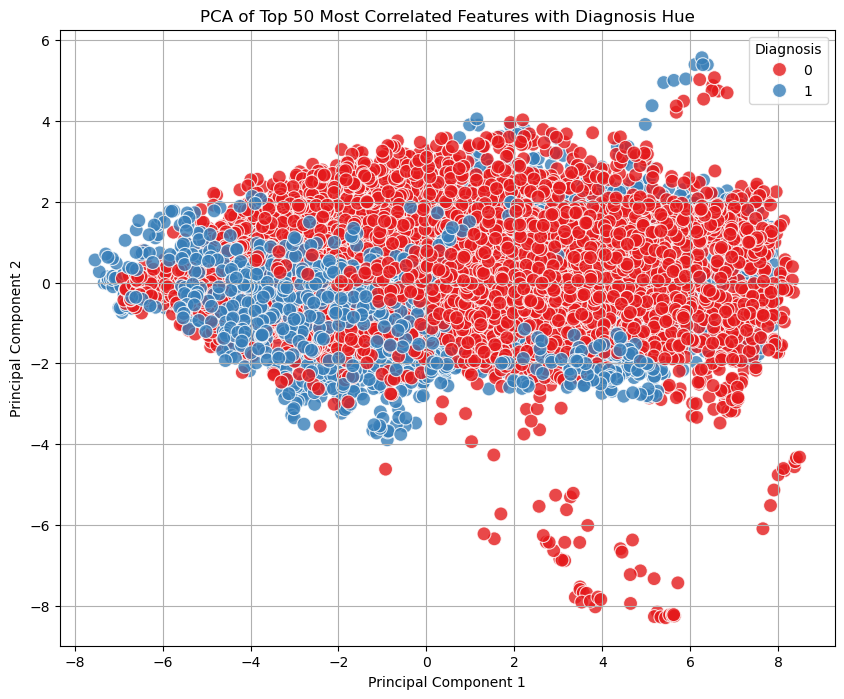

In [57]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(df_top_20)
pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
pca_df['diagnosis'] = y_train
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='diagnosis', data=pca_df, palette='Set1', s=100, alpha=0.8)
plt.title('PCA of Top 50 Most Correlated Features with Diagnosis Hue')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Diagnosis')
plt.grid(True)
plt.show()

In [60]:
theta_beta_features = training_df.filter(regex = 'theta|beta')

<Axes: xlabel='pc1', ylabel='pc2'>

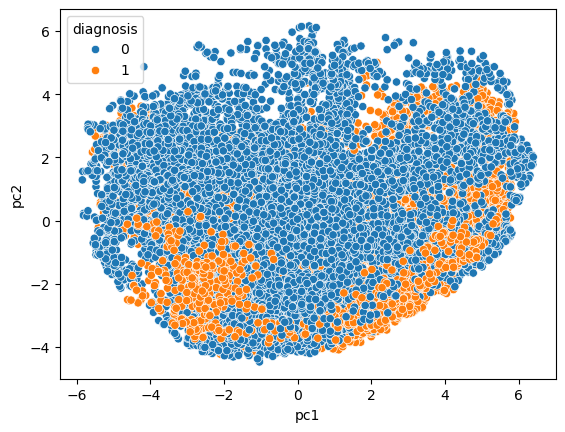

In [64]:
pca_theta_beta = PCA(n_components = 2) 
pca_components = pca_theta_beta.fit_transform(theta_beta_features)
pca_df = pd.DataFrame(data=pca_components, columns = ['pc1', 'pc2'])
pca_df['diagnosis'] = y_train

sns.scatterplot(data = pca_df, x ='pc1', y='pc2', hue ='diagnosis')

### Recursive Feature Elimination

In [80]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

In [90]:
n_estimators = [5,10,15,20,30,40,50]
accuracy_ada = []
accuracy_gradient_boost = []
for n in tqdm(n_estimators):
    gbc = GradientBoostingClassifier(n_estimators=n)
    ada = AdaBoostClassifier(n_estimators=n, algorithm="SAMME")
    
    gbc.fit(X_train, y_train)
    ada.fit(X_train,y_train)

    ada_pred = ada.predict(X_test)
    gbc_pred = gbc.predict(X_test)

    accuracy_ada.append(accuracy_score(y_test,ada_pred))
    accuracy_gradient_boost.append(accuracy_score(y_test, gbc_pred))

100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [06:08<00:00, 52.64s/it]


<Axes: >

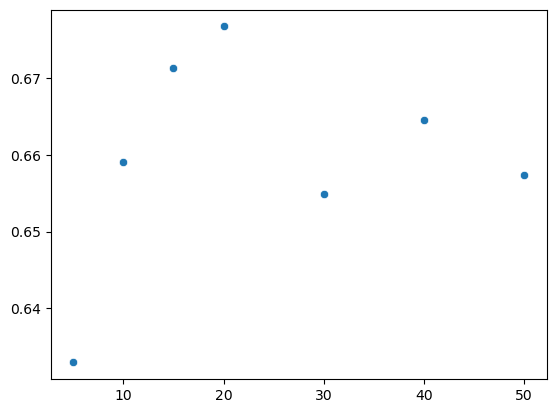

In [91]:
sns.scatterplot(x=n_estimators, y = accuracy_ada)

<Axes: >

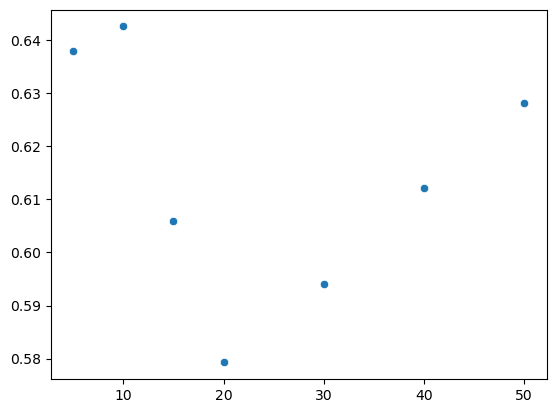

In [92]:
sns.scatterplot(x=n_estimators, y = accuracy_gradient_boost)

In [78]:
estimator = SVC(kernel='rbf')
estimator.fit(X_train, y_train)
rfecv = RFECV(estimator=estimator, step=1, cv=5, scoring='accuracy')

In [79]:
rfecv.fit(X_train, y_train)

ValueError: when `importance_getter=='auto'`, the underlying estimator SVC should have `coef_` or `feature_importances_` attribute. Either pass a fitted estimator to feature selector or call fit before calling transform.

In [ ]:
print("Optimal number of features : %d" % rfecv.n_features_)
print("Selected features indices: ", rfecv.support_)
print("Selected features names: ", np.where(rfecv.support_)[0])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()